# Bayesian Regression with Pyro

See `pyro.ai`
```
$ pip install pyro-ppl
```

In [1]:
import sys
sys.version

'3.7.9 (tags/v3.7.9:13c94747c7, Aug 17 2020, 18:58:18) [MSC v.1900 64 bit (AMD64)]'

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

## Data
The following example is adapted from [1]. We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable rugged in the dataset) and its GDP per capita. In particular, it was noted by the authors in [2] that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations. Let us look at the data and investigate this relationship. We will be focusing on three features from the dataset: 
- cont_africa: whether the given nation is in Africa 
- rugged: quantifies the Terrain Ruggedness Index 
- rgdppc_2000: Real GDP per capita for the year 2000

**References**
1. McElreath, D., Statistical Rethinking, Chapter 7, 2016
2. Nunn, N. & Puga, D., Ruggedness: The blessing of bad geography in Africa”, Review of Economics and Statistics 94(1), Feb. 2012

In [4]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [6]:
df.tail(4)

,cont_africa,rugged,rgdppc_2000
230,0,2.323,6.669180
231,1,1.761,9.150497
232,1,0.533,6.651585
233,1,1.194,7.823732


## Visual Exploration

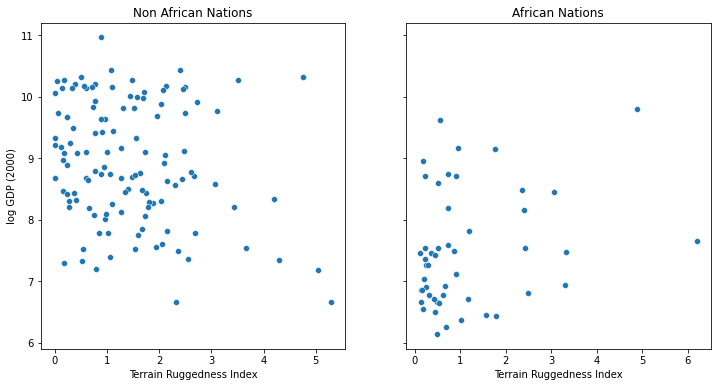

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

## Linear Regression (MLE)

In [16]:
from sklearn.linear_model import LinearRegression
# 1. create linear regression object
regr = LinearRegression()
# 2. fit the model using the data sets
regr.fit(african_nations['rugged'].values[:, np.newaxis], african_nations['rgdppc_2000'].values[:,np.newaxis])
# 3. see the coefficients
print('Linear regression: ', regr.coef_, regr.intercept_)

Linear regression:  [[0.19053672]] [7.27517836]


In [180]:
x = np.linspace(start=african_nations['rugged'].min(), stop=african_nations['rugged'].max(), num=10)
y = regr.predict(x[:,np.newaxis])
y.shape

(10, 1)

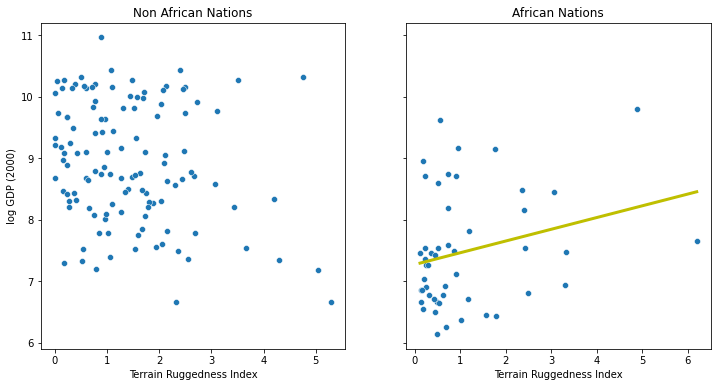

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");
# now plot the regression line
ax[1].plot(x, y, c='y', lw=3);

**E.1** plot the regression line for Non-Arican Nations.

## Full Bayesian Regression

- Apply MCMC technique to obtain random samples from the posterior distrubtion
- The data should be `torch.tensor` not `numpy.array`; 
    - fortunately user interface between the two is 99.9% the same.

In [51]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
data_tt = torch.tensor(df.values, dtype=torch.float).to(device)  # torch tensor
print(data_tt[:2])

# separate data_tt into three arrays with names
is_cont_africa, ruggedness, log_gdp = data_tt[:, 0], data_tt[:, 1], data_tt[:, 2]

cpu
tensor([[1.0000, 0.8580, 7.4926],
        [0.0000, 3.4270, 8.2169]])


In [219]:
# describe your own generative model
def mu_func(is_cont_africa, ruggedness, a, b_a, b_r, b_ar):
    return a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

def model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = mu_func(is_cont_africa, ruggedness, a, b_a, b_r, b_ar)
    mu = pyro.deterministic('mu', mean)  # for convenience later
    
#     with pyro.plate("data", len(ruggedness)):
#         obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)
    obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)
    return obs
#

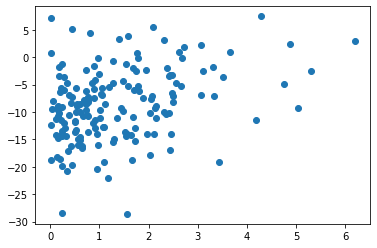

In [220]:
# prior predictive distribution (without observation)
obs_prior = model(is_cont_africa, ruggedness)  # the output will change every time
plt.scatter(ruggedness, obs_prior);

In [221]:
from pyro.infer import MCMC, NUTS
mcmc = MCMC(NUTS(model), num_samples=2000, warmup_steps=1000)
mcmc.run(is_cont_africa, ruggedness, log_gdp)

Sample: 100%|███████████████████████████████████████| 3000/3000 [01:13, 41.06it/s, step size=3.61e-01, acc. prob=0.916]


In [195]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      9.18      0.14      9.18      8.95      9.41    729.31      1.00
        bA     -1.85      0.22     -1.84     -2.23     -1.49    854.46      1.00
        bR     -0.19      0.08     -0.19     -0.32     -0.06    711.72      1.00
       bAR      0.35      0.13      0.35      0.14      0.57    809.75      1.00
     sigma      0.95      0.05      0.95      0.86      1.04   1289.46      1.00

Number of divergences: 0


In [196]:
hmc_samples = mcmc.get_samples()
hmc_samples

{'a': tensor([9.2475, 9.5457, 9.5607,  ..., 9.0548, 9.1711, 9.3588]),
 'bA': tensor([-1.9157, -2.3413, -2.3132,  ..., -1.7653, -1.7442, -2.0094]),
 'bR': tensor([-0.2480, -0.3365, -0.4279,  ..., -0.1527, -0.1600, -0.1758]),
 'bAR': tensor([0.4437, 0.5660, 0.6390,  ..., 0.2716, 0.3436, 0.4445]),
 'sigma': tensor([0.9610, 0.9633, 0.9537,  ..., 1.1263, 0.8046, 1.0501])}

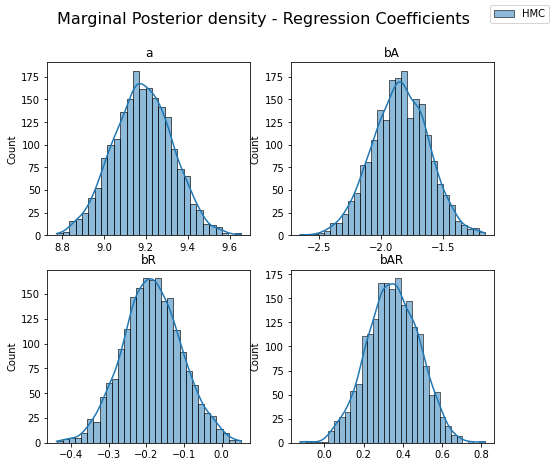

In [197]:
sites = ["a", "bA", "bR", "bAR", "sigma"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 7))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.histplot(hmc_samples[site], ax=ax, label="HMC", kde=True)
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

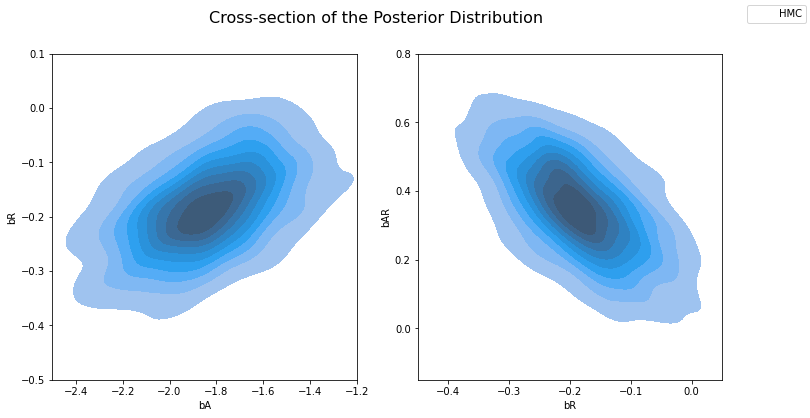

In [198]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=hmc_samples["bA"], y=hmc_samples["bR"], ax=axs[0], shade=True, label="HMC")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(x=hmc_samples["bR"], y=hmc_samples["bAR"], ax=axs[1], shade=True, label="HMC")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

### Posterior Predictive Check

In [217]:
from pyro.infer import Predictive
predictive = Predictive(model, posterior_samples=hmc_samples) #

# predictions will be made for this values
rgdns = torch.tensor(np.linspace(0, ruggedness.max()*1.01, 101), dtype=float) #[0, 1, 2, 3, 4, 5, 6])
ica = torch.tensor([1]*len(rgdns), dtype=torch.float)

# make posterior prediction
ppsamples = predictive(is_cont_africa=ica, ruggedness=rgdns)
pps_obs = ppsamples['obs']; pps.shape

torch.Size([2000, 101])

In [212]:
ppsamples.keys(), ppsamples['mu'].shape

(dict_keys(['obs', 'mu']), torch.Size([2000, 1, 101]))

In [215]:
# posterior HDI with obs noise
hdi_obs = arviz.hdi(pps_obs.numpy(), hdi_prob=.9)  

# posterior HDI without obs noise
hdi = arviz.hdi(ppsamples['mu'].numpy(), hdi_prob=.9)

c:\users\vip\appdata\local\programs\python\python37\lib\site-packages\arviz\stats\stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


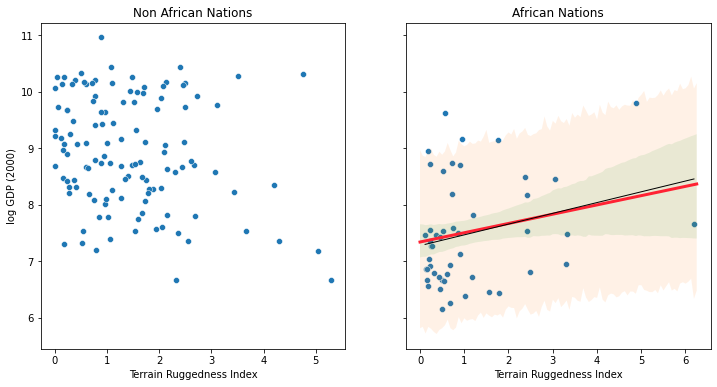

In [218]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");
# now plot the MMCM regression lines and the posterior mean line
mean_sites = [hmc_samples[s].mean() for s in sites]
mean_y = mu_func(1, rgdns, *mean_sites[:-1])
ax[1].plot(rgdns, mean_y, c='#ff2233', lw=3);  # regression line with posterior mean parameters
ax[1].plot(x, y, c='k', lw=1);  # MLE line
ax[1].fill_between(rgdns, hdi_obs[:,0], hdi_obs[:,1], alpha=.1)  # posterior predictive observation with sigma
ax[1].fill_between(rgdns, hdi[:, 0], hdi[:,1], alpha=.1)  # pp observation w/o sigma

In [44]:
# visualization of the result is convenient with `arviz`
import arviz

inferenceData = arviz.from_pyro(mcmc)

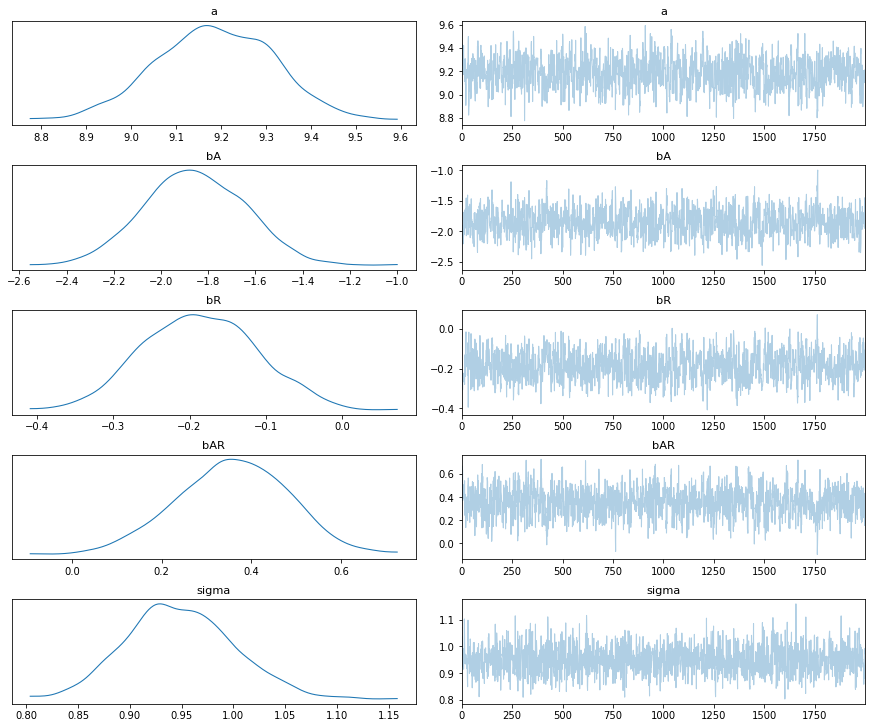

In [45]:
arviz.plot_trace(inferenceData);

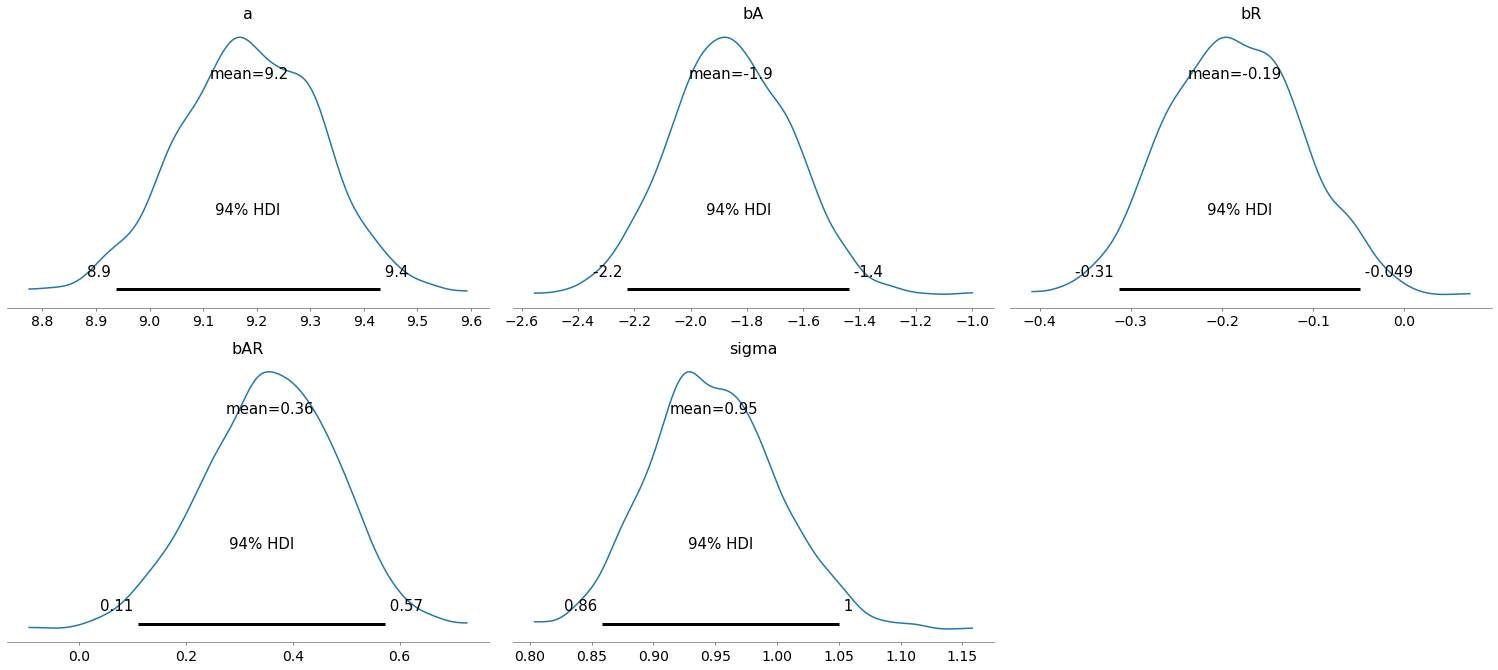

In [75]:
arviz.plot_posterior(inferenceData);

In [154]:
inferenceData.mean()

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data